## Compare LightGBM in the case of binary class (Sell, Buy)

In [46]:
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
import lightgbm as lgb
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    plot_feature_imp,
    plot_strategy,
    backtest_strategy,
    display_report,
    objective_lightgbm,
    select_threshold,
)

In [47]:
METRIC = "precision"
TEST_SIZE = 350
FPR_MAX = 0.025
TIMEOUT = 600

In [48]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [49]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [50]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [51]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [52]:
interest_rate = wk_df["r"].values

## Baseline LightGBM Classifier without new data

In [53]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

### Split dataset

In [54]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [55]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_lightgbm(trial, X_train, y_train, METRIC),
    n_trials=150,
    timeout=TIMEOUT,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-17 00:38:29,535] A new study created in memory with name: no-name-9d81f3bd-af6c-414c-8e97-a90f13ca9719
[I 2024-02-17 00:38:30,085] Trial 0 finished with value: 0.5190853569661031 and parameters: {'lambda_l1': 7.404718208036244e-05, 'lambda_l2': 0.0017734167489736213, 'num_leaves': 242, 'min_sum_hessian_in_leaf': 2.2408746964386374e-05, 'feature_fraction': 0.9412660193861806, 'feature_fraction_bynode': 0.700901728913941, 'bagging_fraction': 0.40951542213203884, 'bagging_freq': 3, 'min_child_samples': 77, 'num_grad_quant_bins': 11, 'max_depth': 6, 'extra_trees': True}. Best is trial 0 with value: 0.5190853569661031.
[I 2024-02-17 00:38:30,263] Trial 1 finished with value: 0.515732859316374 and parameters: {'lambda_l1': 6.783994694771757e-05, 'lambda_l2': 0.005409181413953853, 'num_leaves': 237, 'min_sum_hessian_in_leaf': 1.2849522382878182e-05, 'feature_fraction': 0.9899342275785848, 'feature_fraction_bynode': 0.7250470433988445, 'bagging_fraction': 0.3802247462577368, 'baggin

Number of finished trials: 150
Best trial:
  Value: 0.6694685980702805
  Params: 
    lambda_l1: 0.00020581671089787282
    lambda_l2: 0.000829511260821603
    num_leaves: 150
    min_sum_hessian_in_leaf: 1.2113918468851378e-05
    feature_fraction: 0.9294070587692168
    feature_fraction_bynode: 0.6099329539307737
    bagging_fraction: 0.8968467228679087
    bagging_freq: 6
    min_child_samples: 5
    num_grad_quant_bins: 11
    max_depth: 16
    extra_trees: False


In [56]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **trial.params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": "average_precision",
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [57]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.8968467228679087,
                                bagging_freq=6, extra_trees=False,
                                feature_fraction=0.9294070587692168,
                                feature_fraction_bynode=0.6099329539307737,
                                lambda_l1=0.00020581671089787282,
                                lambda_l2=0.000829511260821603, max_depth=16,
                                metric='average_precision', min_child_samples=5,
                                min_sum_hessian_in_leaf=1.2113918468851378e-05,
                                num_grad_quant_bins=11, num_leaves=150,
                                objective='binary', random_state=1968,
                                verbosity=-1))])

In [58]:
# In-sample score
pipe.score(X_train, y_train)

1.0

In [59]:
in_sample_preds = pipe.predict(X_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       582
           1       1.00      1.00      1.00       576

    accuracy                           1.00      1158
   macro avg       1.00      1.00      1.00      1158
weighted avg       1.00      1.00      1.00      1158



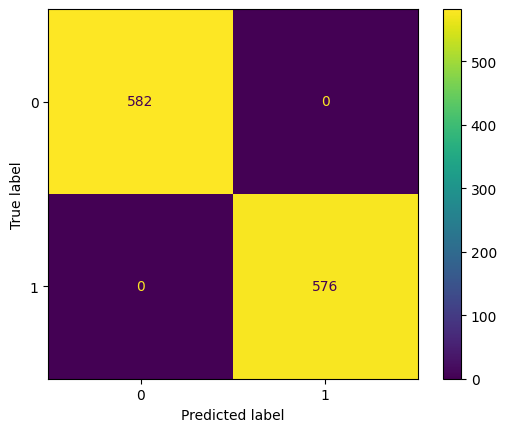

In [60]:
display_report(y_train, in_sample_preds)

In [61]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.84


In [62]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [63]:
pipe.score(X_test, y_test)

0.5342857142857143

              precision    recall  f1-score   support

           0       0.61      0.59      0.60       194
           1       0.51      0.53      0.52       156

    accuracy                           0.56       350
   macro avg       0.56      0.56      0.56       350
weighted avg       0.56      0.56      0.56       350



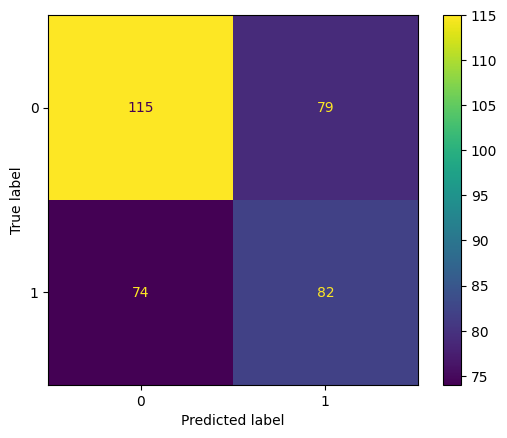

In [64]:
display_report(y_test, predictions)

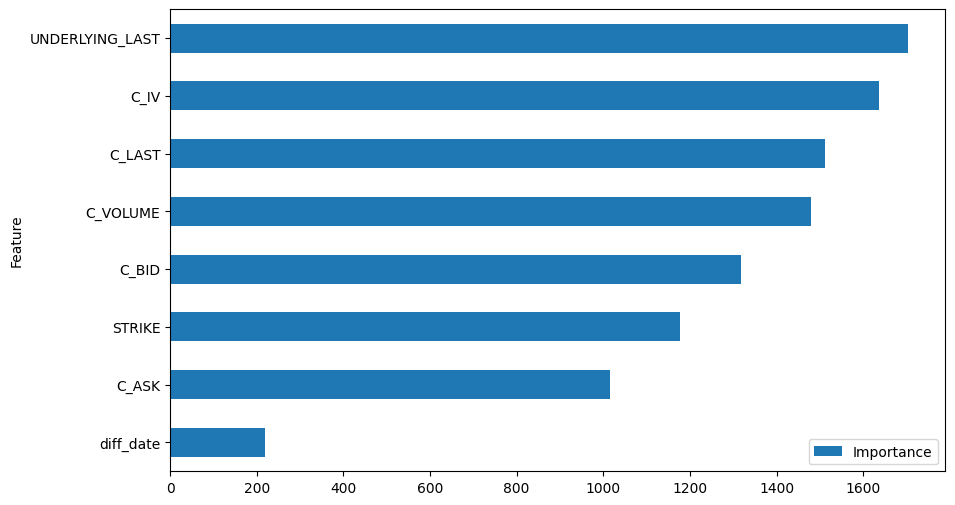

In [65]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [66]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_out"])

### Backtesting

In [67]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [68]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-08-12,1,427.0,7.25,2022-09-02,392.239990,-7.25,-7.250000,-7.250000,-7.250000
2022-08-15,0,429.0,7.18,2022-09-06,390.760010,0.00,-7.180000,-7.250000,-14.430000
2022-08-16,0,430.0,6.90,2022-09-06,390.760010,0.00,-6.900000,-7.250000,-21.330000
2022-08-17,0,426.0,7.66,2022-09-07,397.779999,0.00,-7.660000,-7.250000,-28.990000
2022-08-18,1,428.0,6.56,2022-09-07,397.779999,-6.56,-6.560000,-13.810000,-35.550000
...,...,...,...,...,...,...,...,...,...
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.00,-3.020007,192.220089,254.689880
2023-12-26,0,476.0,6.12,2024-01-19,482.429993,0.00,0.309993,192.220089,254.999873
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.00,0.239993,192.220089,255.239866


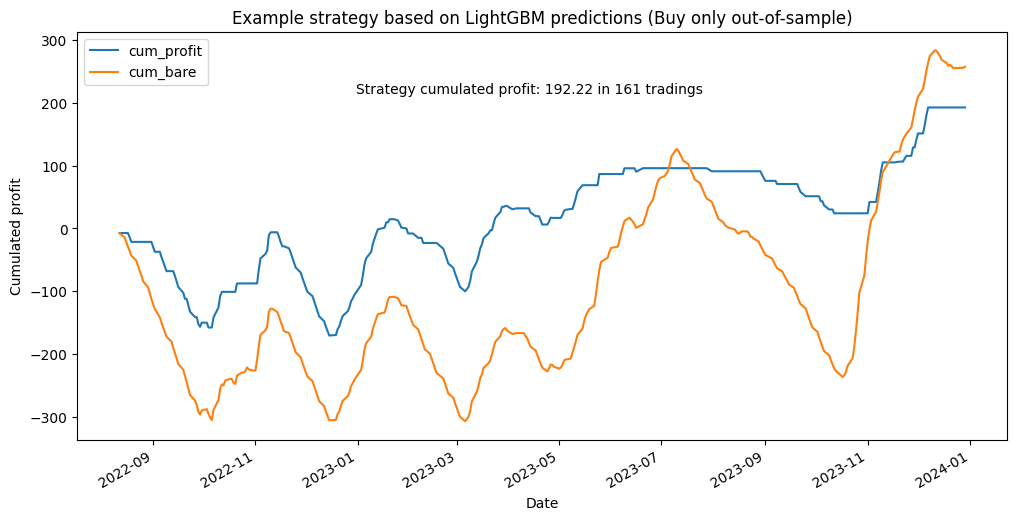

In [69]:
plot_strategy(strategy_df, "LightGBM", "(Buy only out-of-sample)")

In [70]:
compare_df["cum_profit_out"] = strategy_df["cum_profit"].values

## LightGBM with data from MC simulation and additional features

In [71]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike", "r"], axis=1),
    ),
    axis=1,
)

In [72]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [74]:
# Set hash seed for reproducibility
hashseed = os.getenv("PYTHONHASHSEED")
os.environ["PYTHONHASHSEED"] = "0"
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=1968, n_startup_trials=0),
)
study.optimize(
    lambda trial: objective_lightgbm(trial, X_train, y_train, METRIC),
    n_trials=150,
    timeout=TIMEOUT * 2,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
# Restore hash seed
if hashseed is not None:
    os.environ["PYTHONHASHSEED"] = hashseed

[I 2024-02-17 00:39:38,992] A new study created in memory with name: no-name-760c853d-5883-476e-9a1b-e20915865726


[I 2024-02-17 00:39:39,428] Trial 0 finished with value: 0.5584887161412118 and parameters: {'lambda_l1': 7.404718208036244e-05, 'lambda_l2': 0.0017734167489736213, 'num_leaves': 242, 'min_sum_hessian_in_leaf': 2.2408746964386374e-05, 'feature_fraction': 0.9412660193861806, 'feature_fraction_bynode': 0.700901728913941, 'bagging_fraction': 0.40951542213203884, 'bagging_freq': 3, 'min_child_samples': 77, 'num_grad_quant_bins': 11, 'max_depth': 6, 'extra_trees': True}. Best is trial 0 with value: 0.5584887161412118.
[I 2024-02-17 00:39:39,890] Trial 1 finished with value: 0.5605463556011764 and parameters: {'lambda_l1': 6.783994694771757e-05, 'lambda_l2': 0.005409181413953853, 'num_leaves': 237, 'min_sum_hessian_in_leaf': 1.2849522382878182e-05, 'feature_fraction': 0.9899342275785848, 'feature_fraction_bynode': 0.7250470433988445, 'bagging_fraction': 0.3802247462577368, 'bagging_freq': 3, 'min_child_samples': 79, 'num_grad_quant_bins': 11, 'max_depth': 5, 'extra_trees': True}. Best is tri

Number of finished trials: 150
Best trial:
  Value: 0.7238521729630732
  Params: 
    lambda_l1: 0.03839638505401026
    lambda_l2: 0.011567942445771567
    num_leaves: 211
    min_sum_hessian_in_leaf: 8.030399503091197e-05
    feature_fraction: 0.2311029398259283
    feature_fraction_bynode: 0.9391625356212262
    bagging_fraction: 0.939410022461864
    bagging_freq: 7
    min_child_samples: 5
    num_grad_quant_bins: 8
    max_depth: 14
    extra_trees: False


In [75]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **study.best_params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": "average_precision",
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [76]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.939410022461864,
                                bagging_freq=7, extra_trees=False,
                                feature_fraction=0.2311029398259283,
                                feature_fraction_bynode=0.9391625356212262,
                                lambda_l1=0.03839638505401026,
                                lambda_l2=0.011567942445771567, max_depth=14,
                                metric='average_precision', min_child_samples=5,
                                min_sum_hessian_in_leaf=8.030399503091197e-05,
                                num_grad_quant_bins=8, num_leaves=211,
                                objective='binary', random_state=1968,
                                verbosity=-1))])

In [77]:
# In-sample score
pipe.score(X_train, y_train)

1.0

In [78]:
in_sample_preds = pipe.predict(X_train)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       582
           1       1.00      1.00      1.00       576

    accuracy                           1.00      1158
   macro avg       1.00      1.00      1.00      1158
weighted avg       1.00      1.00      1.00      1158



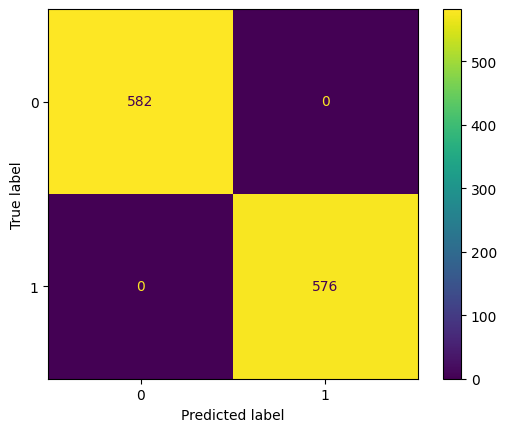

In [79]:
display_report(y_train, in_sample_preds)

In [80]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=FPR_MAX
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.93


In [81]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [82]:
pipe.score(X_test, y_test)

0.52

              precision    recall  f1-score   support

           0       0.62      0.79      0.69       194
           1       0.60      0.39      0.47       156

    accuracy                           0.61       350
   macro avg       0.61      0.59      0.58       350
weighted avg       0.61      0.61      0.59       350



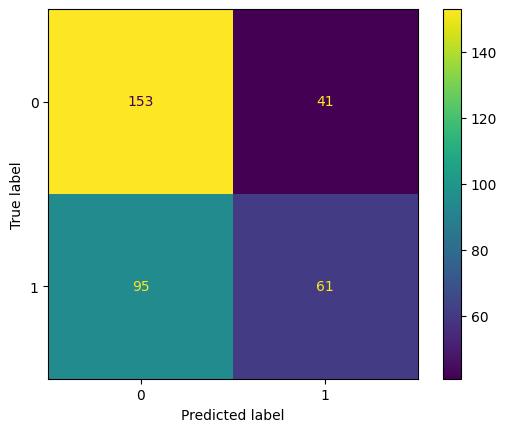

In [83]:
display_report(y_test, predictions)

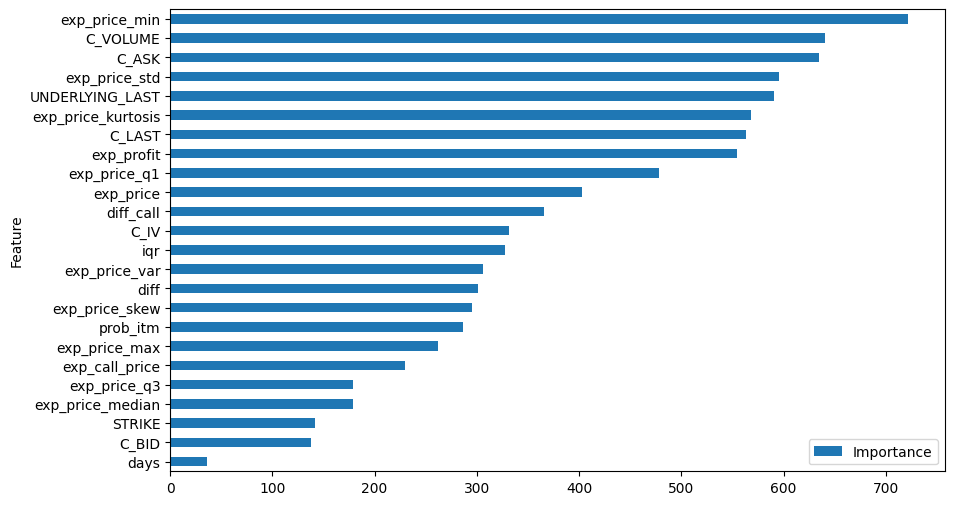

In [84]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [85]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [86]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [87]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-08-12,0,427.0,7.25,2022-09-02,392.239990,0.0,-7.250000,0.000000,-7.250000
2022-08-15,0,429.0,7.18,2022-09-06,390.760010,0.0,-7.180000,0.000000,-14.430000
2022-08-16,0,430.0,6.90,2022-09-06,390.760010,0.0,-6.900000,0.000000,-21.330000
2022-08-17,0,426.0,7.66,2022-09-07,397.779999,0.0,-7.660000,0.000000,-28.990000
2022-08-18,0,428.0,6.56,2022-09-07,397.779999,0.0,-6.560000,0.000000,-35.550000
...,...,...,...,...,...,...,...,...,...
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.0,-3.020007,321.989998,254.689880
2023-12-26,0,476.0,6.12,2024-01-19,482.429993,0.0,0.309993,321.989998,254.999873
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.0,0.239993,321.989998,255.239866


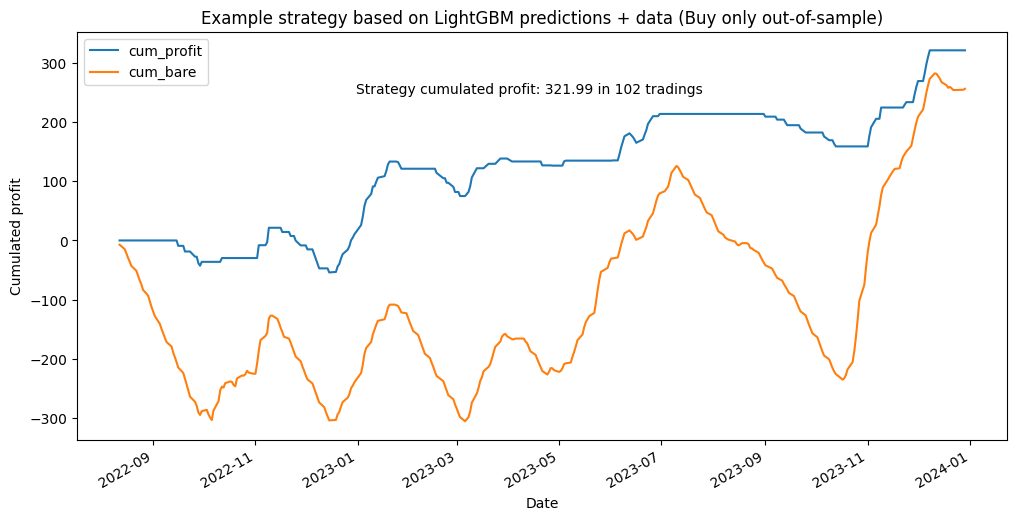

In [88]:
plot_strategy(strategy_df, "LightGBM", "+ data (Buy only out-of-sample)")

In [89]:
compare_df["mmar_cum_profit_out"] = strategy_df["cum_profit"].values
compare_df["mmar_cum_bare_out"] = strategy_df["cum_bare"].values

## Compare the two predictions

In [90]:
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [91]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_out,cum_profit_out,mmar_rf_pred_out,mmar_cum_profit_out,mmar_cum_bare_out
0,1,-7.250000,0,0.000000,-7.250000
4,1,-13.810000,0,0.000000,-35.550000
5,1,-21.260000,0,0.000000,-43.000000
14,1,-28.860000,0,0.000000,-119.800000
15,1,-36.930000,0,0.000000,-127.870000
...,...,...,...,...,...
316,1,104.980116,0,225.110039,89.699926
322,1,106.250128,0,225.110039,122.279993
327,1,128.880109,0,234.220026,173.779933
328,0,128.880109,1,247.900020,187.459927


In [92]:
compare_df[mask_out].shape

(103, 5)

In [93]:
compare_df.sum(axis=0)

bare_rf_pred_out         161.000000
cum_profit_out          5375.193160
mmar_rf_pred_out         102.000000
mmar_cum_profit_out    42217.499502
mmar_cum_bare_out     -35888.316993
dtype: float64

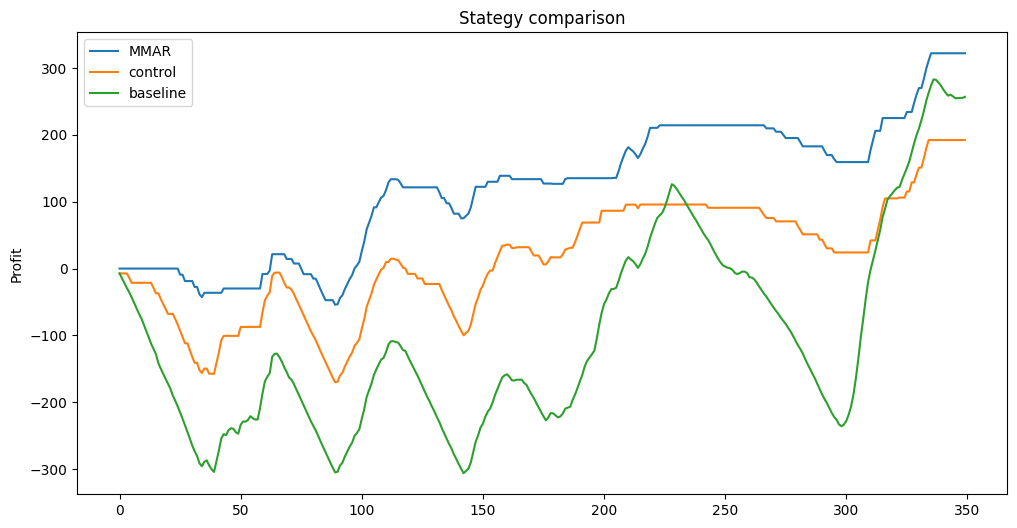

In [94]:
compare_df[["mmar_cum_profit_out", "cum_profit_out", "mmar_cum_bare_out"]].rename(
    {
        "mmar_cum_profit_out": "MMAR",
        "cum_profit_out": "control",
        "mmar_cum_bare_out": "baseline",
    },
    axis=1,
).plot(figsize=(12, 6), title="Stategy comparison", ylabel="Profit")
plt.show()